STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

torch: 1.8.1+cu111



# WGAN-GP Trained on MNIST

## Imports

In [2]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [3]:
import sys
sys.path.append('../')

from helper_data import get_dataloaders_mnist
from helper_train import train_wgan_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_multiple_training_losses
from helper_plotting import plot_generated_images

In [4]:
##########################
### SETTINGS
##########################

# Device
#CUDA_DEVICE_NUM = 3
#DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 42

# WGAN usually works bettern with smaller learning 
# rates compared to regular GANs
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 100
BATCH_SIZE = 128

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 28, 28, 1

Device: cpu


In [5]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [6]:
##########################
### Dataset
##########################

from torchvision import datasets
from torch.utils.data import DataLoader


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=custom_transforms,
                               download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [7]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


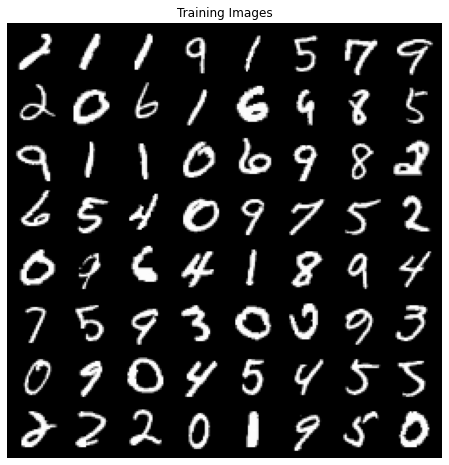

In [8]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], 
                                         padding=2, normalize=True),
                        (1, 2, 0)))
plt.show()

## Model

In [9]:
##########################
### MODEL
##########################

class GAN(torch.nn.Module):

    def __init__(self, latent_dim=100, 
                 image_height=28, image_width=28, color_channels=1):
        super().__init__()
        
        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels
        
        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, image_height*image_width*color_channels),
            nn.Tanh()
        )
        
        # in WGAN, discriminator is actually called "critic"
        self.discriminator = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_height*image_width*color_channels, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1), # outputs logits
            #nn.Sigmoid()
        )
    
    def generator_forward(self, z):# z has dimension NCHW
        z = torch.flatten(z, start_dim=1) 
        img = self.generator(z)
        img = img.view(z.size(0),
                       self.color_channels,
                       self.image_height,
                       self.image_width)
        return img
    
    def discriminator_forward(self, img):
        logits = model.discriminator(img)
        return logits

In [10]:
set_all_seeds(RANDOM_SEED)

model = GAN()
model.to(DEVICE)


optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

## Training

In [11]:
log_dict = train_wgan_v1(num_epochs=NUM_EPOCHS,
                         model=model, 
                         optimizer_gen=optim_gen,
                         optimizer_discr=optim_discr,
                         latent_dim=100,
                         discr_iter_per_generator_iter=5,
                         gradient_penalty_weight=10,
                         device=DEVICE, 
                         gradient_penalty=True,
                         train_loader=train_loader,
                         logging_interval=100,
                         save_model='gan_mnist_01.pt')

Epoch: 001/100 | Batch 000/469 | Gen/Dis Loss: 0.0840/4.7646
Epoch: 001/100 | Batch 100/469 | Gen/Dis Loss: -13.8253/-4.6498
Epoch: 001/100 | Batch 200/469 | Gen/Dis Loss: -16.9301/-1.5706
Epoch: 001/100 | Batch 300/469 | Gen/Dis Loss: -16.9869/-0.7813
Epoch: 001/100 | Batch 400/469 | Gen/Dis Loss: -16.9459/-0.3559
Time elapsed: 0.27 min
Epoch: 002/100 | Batch 000/469 | Gen/Dis Loss: -15.7711/0.1564
Epoch: 002/100 | Batch 100/469 | Gen/Dis Loss: 0.0000/0.0516
Epoch: 002/100 | Batch 200/469 | Gen/Dis Loss: -14.1856/-0.0935
Epoch: 002/100 | Batch 300/469 | Gen/Dis Loss: -13.3109/-0.0087
Epoch: 002/100 | Batch 400/469 | Gen/Dis Loss: 0.0000/-0.0631
Time elapsed: 0.54 min
Epoch: 003/100 | Batch 000/469 | Gen/Dis Loss: -13.4660/-0.4070
Epoch: 003/100 | Batch 100/469 | Gen/Dis Loss: -10.7516/-0.1993
Epoch: 003/100 | Batch 200/469 | Gen/Dis Loss: -11.2882/0.0976
Epoch: 003/100 | Batch 300/469 | Gen/Dis Loss: -9.8136/0.2870
Epoch: 003/100 | Batch 400/469 | Gen/Dis Loss: -9.8029/-0.0745
Time el

## Evaluation

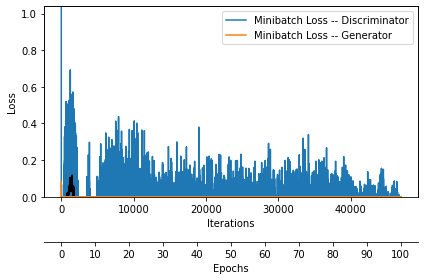

In [12]:
plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS, 
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

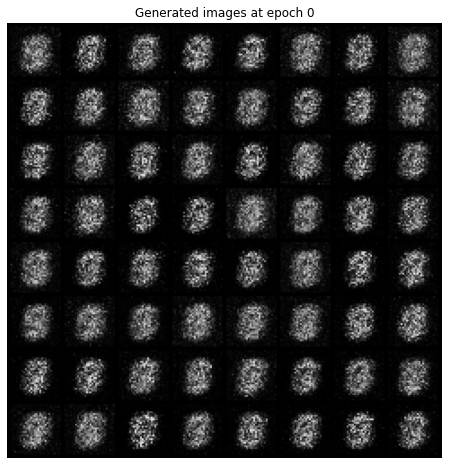

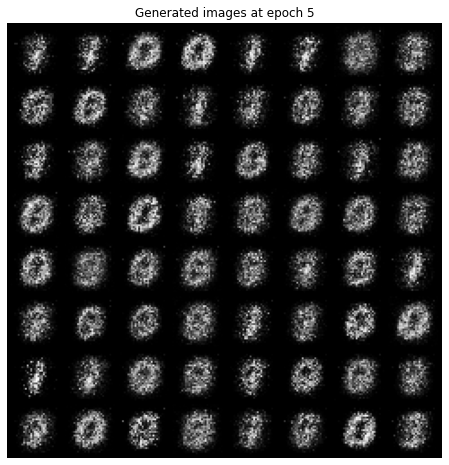

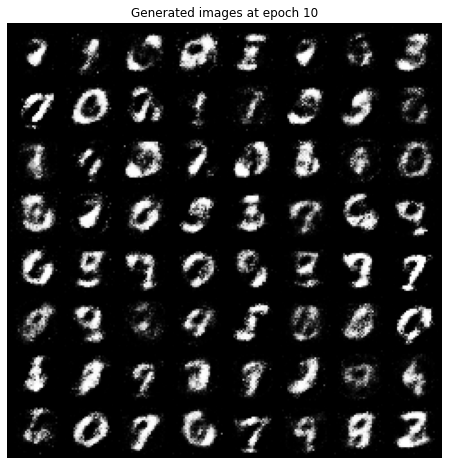

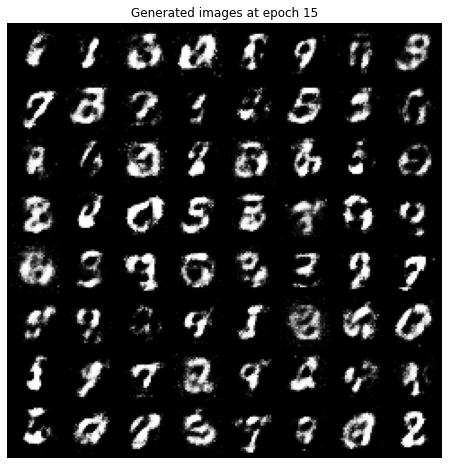

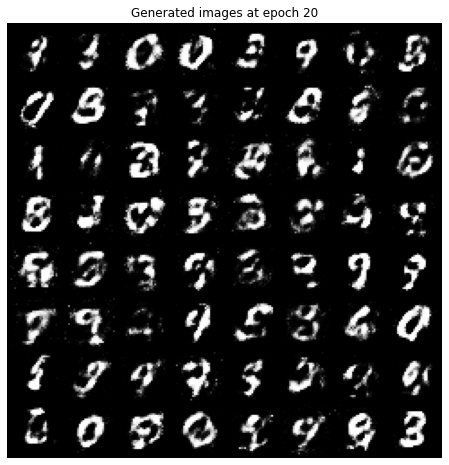

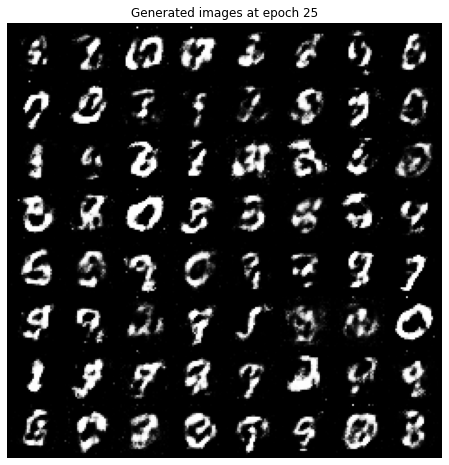

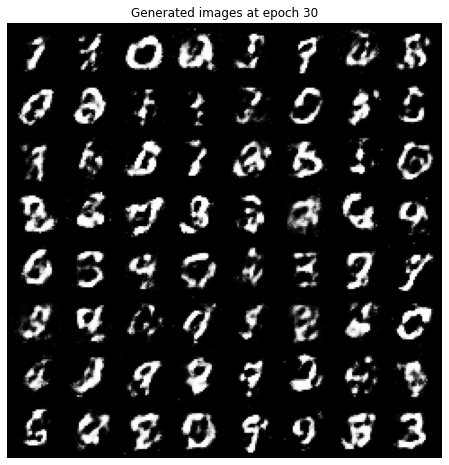

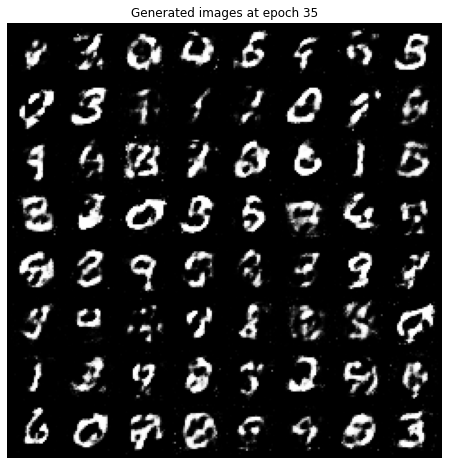

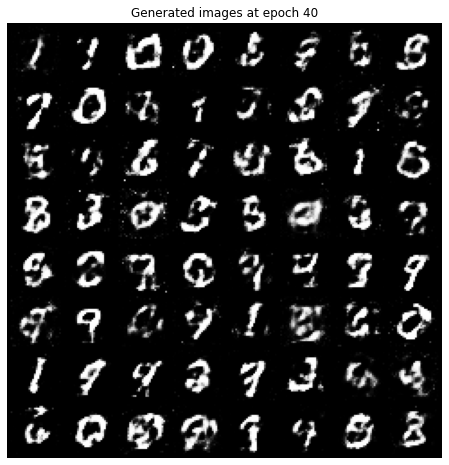

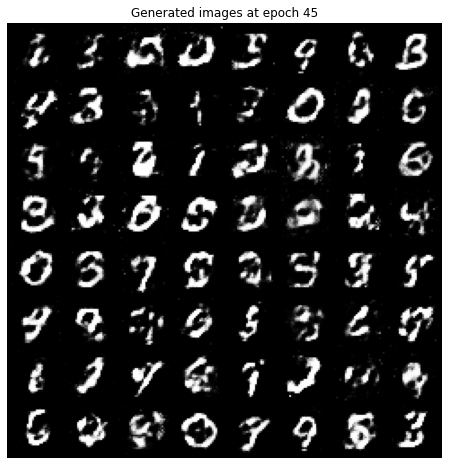

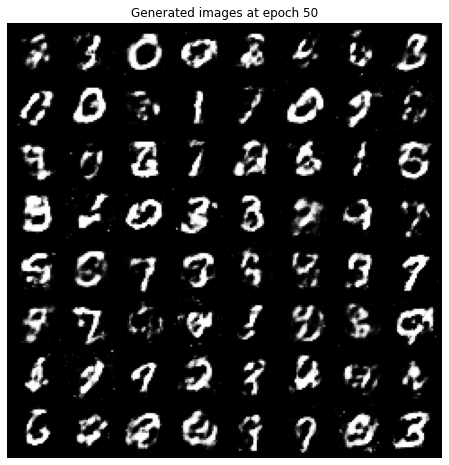

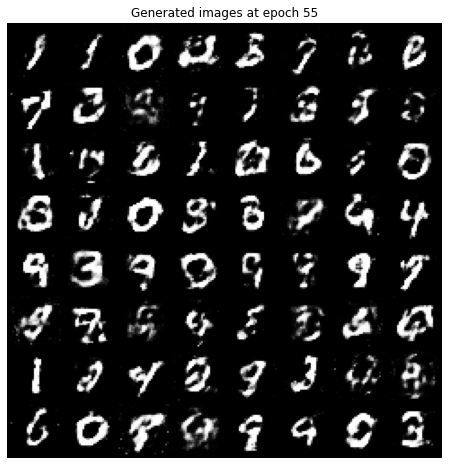

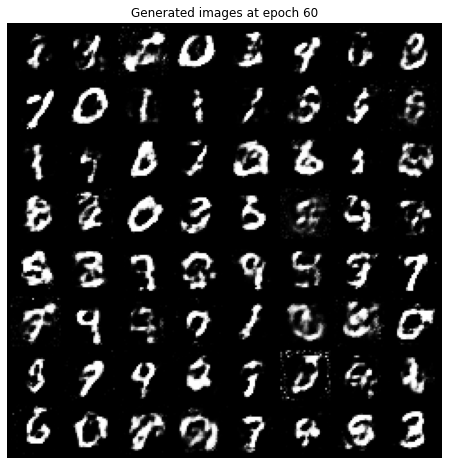

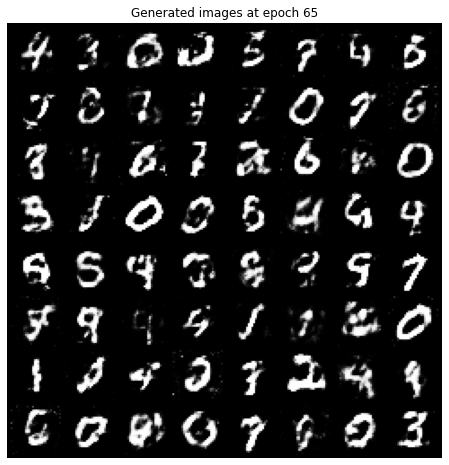

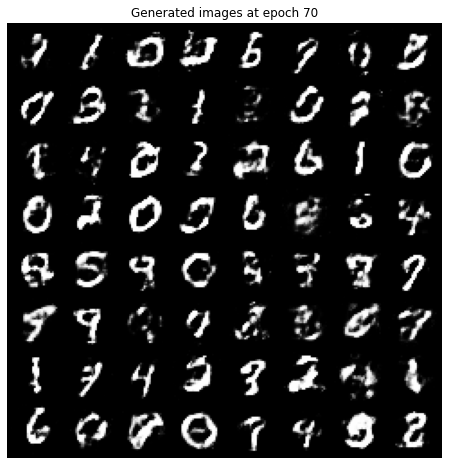

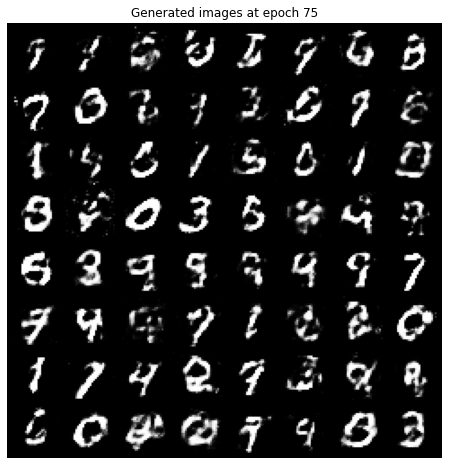

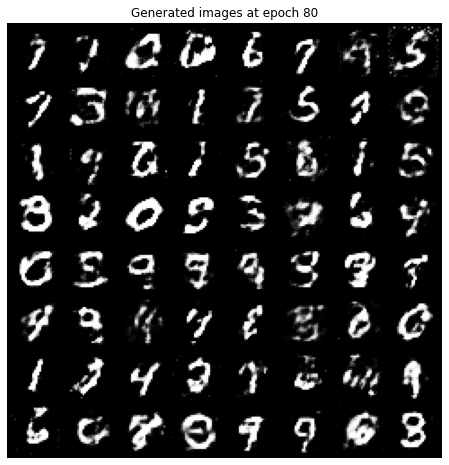

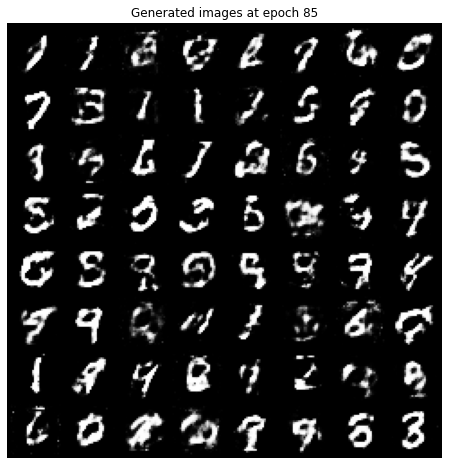

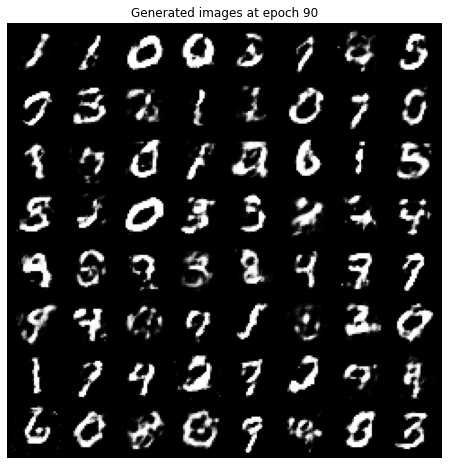

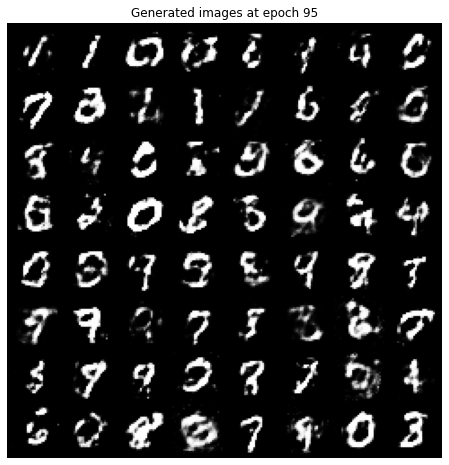

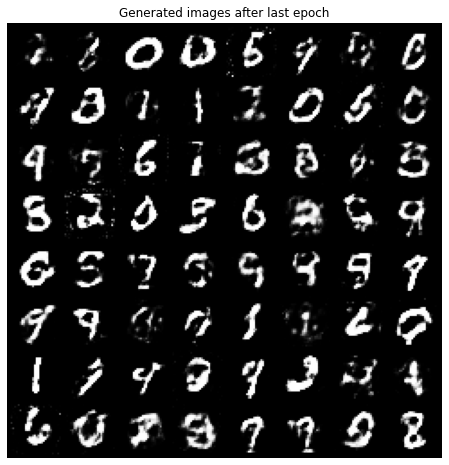

In [13]:
##########################
### VISUALIZATION
##########################

for i in range(0, NUM_EPOCHS, 5):
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()
    
    
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()